# Scikit-Learn: Building the Pipeline
The Pipeline is an extremely powerful feature of the Scikit-Learn library. Not only do Pipelines effectively create more modular and less error-prone code (always a huge plus), they enable efficient evaluation and re-use of the workflows and models encapsulated within this paradigm.

If you are unfamiliar with the basics of Machine Learning modeling or Scikit Pipelines, Kaggle has a set of excellent tutorials that will help get you started: 
[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) and
[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)

Our goals for this notebook are:
- Load and become familiar with the Kaggle House Price Prediction dataset
- Build a baseline regression model using a Pipeline
- Build a custom Transformer class using the TransformerMixin
- Explore more advanced options to include in our Pipeline

## Data Exploration
Lets start by loading the data from the [Kaggle Housing Price Competition](https://www.kaggle.com/c/home-data-for-ml-course). The test and train csv files can be found [here](https://www.kaggle.com/c/home-data-for-ml-course/data)

The following code will load these files if they are stored in the 'data' folder under your Jupyter Notebook working directory. Note that this path may need to be adjusted depending on your OS.

In [1]:
import os
import pandas as pd

# Get the train/test csv file paths in the 'data' folder of the working directory
test_path = os.path.join(os.getcwd(), 'data\\test.csv')
train_path = os.path.join(os.getcwd(), 'data\\train.csv')

# Covert the files to Pandas DataFrame objects
test_df = pd.read_csv(test_path, index_col='Id')
train_df = pd.read_csv(train_path, index_col='Id')

Its standard practice to inspect the first few rows of the dataset to get a picture of what we are dealing with...

In [2]:
# Print the first few rows (default=5)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Based on the competition description our target variable is 'SalePrice'. Lets take a closer look at the SalePrice column using the describe() method

In [3]:
# Get a statistical breakdown of the SalePrice column
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The SalePrice variable is continuous, meaning that we will need to use regression based techniques to predict the target from the included data. The corr() method returns the correlation values between every numerical feature in the DataFrame. We can focus on just the SalePrice column to get an idea of how strongly correlated its values are to every other feature.

In [4]:
# Corr() values are only calculated for numerical columns
train_df.corr()['SalePrice'].shape

(37,)

In [5]:
# Print the features with the top 10 highest correlation values
train_df.corr()['SalePrice'].sort_values().tail(10)

YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

The conventional names for our input and target subsets are X and y respectively. We start by dropping all rows that do not contain a valid target entry as they are not usefull for this task. For this dataset all 1460 rows are non-null but we perform this step as best-practice.

In [6]:
# Remove all rows where the target is NaN or Null
train_df.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Create target and input objects
y = train_df.SalePrice
X = train_df.drop(columns='SalePrice')

Based on this initial inspection the dataset contains a number of 'NaN' values. Dealing with these null entries is one of the major considerations we must take into account as we build our model and pipeline.

Columns containing a very high rate of null entries (and subsequently a low variance) may have negative effects on our models predictive power.

We can get a sense of which columns contain the greatest number of null entries by using the isnull() method

In [7]:
# Print the top 10 columns ordered by number of null entries
X.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

Another major consideration that affects the way we structure our pipeline is the difference between our two primary data types, numerical and categorical values.

The strategies for dealing with each is beyond the scope of this notebook.  We can separate the two feature groupings and inspect them individually in the following manner.

In [8]:
# Select numeric data columns
num_cols = [c for c in X.columns if X[c].dtype in ('int64', 'float64')]
X_num = X[num_cols]
num_count = len(num_cols)

# Select categoric data columns
X_cat = X.select_dtypes(include=['object'])
cat_cols = list(X.columns)
cat_count = X_cat.shape[1]

print("Numerical columns: {}\n{}".format(num_count, num_cols))
print("Categorical columns: {}\n{}".format(cat_count, cat_cols))

Numerical columns: 36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical columns: 43
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFi

In [9]:
X_cat

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In order to take advantage of the 43 columns of categorical data in this dataset we will need to encode the information in a numerical form. The tutorials linked at the beginning of this articles touch on several different encoding methods. We will use the OrdinalEncoder to apply an integer based label to each unique category on a per-column basis.

In [10]:
from category_encoders.ordinal import OrdinalEncoder

X_cat_enc = OrdinalEncoder().fit_transform(X_cat)
X_cat_enc.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,2,1,2,2,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,2,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,2,1,1,3,1,3,1,...,2,2,1,1,1,1,1,1,1,2
5,1,1,1,2,1,1,2,1,4,1,...,1,1,1,1,1,1,1,1,1,1


## Setting the Baseline
Now that we have a better idea of what we are workng with let's dig into Pipelines. If you aren't familiar with Scikit-learn and the Pipeline object take a look at Kaggle's Intermediate ML tutorial linked above. We will start by building a minimally functinal baseline that will allow us to gauge the effectiveness of our efforts.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

def evaluate_pipeline(model_pipe, X, y):
    # Use 3 fold cross validation to evaluate the Pipeline
    mae_scores = -1 * cross_val_score(
        model_pipe, X, y, cv=3, scoring='neg_mean_absolute_error'
    )
    print('CV MAE: {}, Mean MAE: {}'.format(mae_scores, mae_scores.mean()))
    return mae_scores.mean()

# Select numerical columns and apply mean imputation
num_cols = [c for c in X.columns if X[c].dtype in ['float64', 'int64']]
col_trans = ColumnTransformer([('num_trans', SimpleImputer(), num_cols)])

# Use a very simple LinearRegression model for these tests
numerical_pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', LinearRegression())
])

# Print the fold and mean baseline MAE scores
mae_mean = evaluate_pipeline(numerical_pipe, X, y)

CV MAE: [22797.72151518 21844.07067599 22847.31374809], Mean MAE: 22496.3686464225


Thats a start, but we are throwing away all of the data in our 43 categorical columns. By applying OrdinalEncoding to these columns in the ColumnTransformer we are no longer discarding all of this potentially useful information.  The OrdinalEncoder object is able to handle both unknown and NaN values so explicit imputation is not required. See the [Category Encoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) documentation for more information.

In [12]:
# Select categorical columns
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

# Combine imputed numerical and encoded categorical features
col_trans = ColumnTransformer([
    ('num_trans', SimpleImputer(), num_cols),
    ('cat_trans', OrdinalEncoder(), cat_cols)
])

# Update our pipeline
simple_pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', LinearRegression())
])

# Check the difference in error when we include categorical data
mae_mean = evaluate_pipeline(simple_pipe, X, y)

CV MAE: [21336.31393462 21981.48313237 22506.23476036], Mean MAE: 21941.34394245071


Let's make one final addition to our baseline: the VarianceThreshold selector. This transformer drops any features that has a variance greater than the threshold value. This will allow us to eliminate features that are potentially weakening our model (due to overfitting) and provides an adequate baseline for our custom transformer in the next section.

In [13]:
from sklearn.feature_selection import VarianceThreshold

# Add the VarianceThreshold transformation to our Pipeline
simple_pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('drop', VarianceThreshold(threshold=0.05)),
    ('model', LinearRegression())
])

# Collect results to compare against a custom transformer
mae_mean = evaluate_pipeline(simple_pipe, X, y)

CV MAE: [20933.50749739 21852.34465505 20996.99370094], Mean MAE: 21260.948617793038


## Custom Transformers
Scikit-learn contains a variety of models and transformers to use in your Pipeline. If you don't find your desired transformer you can use the TransformerMixin or FunctionTransformer to implement it yourself. In this section we will build a custom transformer and compare it against the VarienceThreshold baseline we introduced in the last section.

To begin, lets work through the details of our experimental transformer. Instead of using feature variance to drop selected data columns we will run a univariate regression analysis on each column and select only the columns that display statistically significant correlation with our target variable.

Before we build the transformer we can step through the process to validate the concept:

In [14]:
from sklearn.feature_selection import f_regression

X_num_imputed = SimpleImputer().fit_transform(X_num, y)
f_array, p_array = f_regression(X_num_imputed, y)

p_max = 0.001
f_start = X_num.shape[1]
f_end = X_num.columns[p_array <= p_max].shape[0]

print("Starting/ending numerical features: {}/{}".format(f_start, f_end))
X_num.columns[(p_array <= p_max)]

Starting/ending numerical features: 36/27


Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'PoolArea'],
      dtype='object')

Now we can implement the above transformation using the TransformerMixin class. We create a new class and inherit from this base class, implementing the fit and transform functions. Note that our input data X is converted to a numpy.ndarray type and therefore you won't have access to the column labels.

In [20]:
from sklearn.base import TransformerMixin

# Create our experimental transformer class
class FeatureSelector(TransformerMixin):
    def __init__(self, p_val=0.05, verbose=False):
        self.col_mask = []  # Boolean mask of columns we want to keep
        self.p_val = p_val  # Maximum regression p-value
        self.verbose = verbose
    
    def fit(self, X, y=None):
        f_array, p_array = f_regression(X, y, False)
        self.col_mask = p_array <= self.p_val
        if self.verbose:
            print("Selected features: {}".format(self.col_mask.sum()))
        return self  # The fit function returns self by convention
    
    def transform(self, X):
        return X[:, self.col_mask]  # Apply the mask to the data array

# Replace the VarianceThreshold transformer with the custom transformer
custom_pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('selector', FeatureSelector(p_val=0.001, verbose=True)),
    ('model', LinearRegression())
])

# Now we can evaluate our new selector...
mae_mean = evaluate_pipeline(custom_pipe, X, y)

Selected features: 77
Selected features: 78
Selected features: 76
CV MAE: [21346.04857066 21827.79731748 20753.37795763], Mean MAE: 21309.074615257265


Our feature selector is underperforming when compared with VarienceThreshold. We are using arbitrarily selected values for each of these transformers so we really don't know how they stack up when these values change. The next step is to plot the MAE values from each transformer over a range of parameter values.

Evaluating VarianceThreshold...
CV MAE: [20852.1932356  21691.6543131  20832.19860839], Mean MAE: 21125.34871902972
CV MAE: [20628.10687341 21888.074121   20649.33497246], Mean MAE: 21055.171988959086
CV MAE: [20663.24718963 21548.06534471 20560.45890025], Mean MAE: 20923.92381153014
CV MAE: [20663.24718963 21548.06534471 20695.40154696], Mean MAE: 20968.90469376692
CV MAE: [20663.24718963 21622.8205908  20695.40154696], Mean MAE: 20993.82310913028
CV MAE: [20608.27894737 21622.8205908  20706.95985958], Mean MAE: 20979.353132582586
CV MAE: [20621.49791048 21955.13466223 20730.9060351 ], Mean MAE: 21102.512869271082
CV MAE: [20621.49791048 21983.40687111 21176.65935005], Mean MAE: 21260.521377214478
CV MAE: [20621.49791048 21983.40687111 21176.65935005], Mean MAE: 21260.521377214478
CV MAE: [20621.49791048 21983.40687111 21176.65935005], Mean MAE: 21260.521377214478

Evaluating FeatureSelector...
CV MAE: [21336.31393462 21981.48313237 20755.5238743 ], Mean MAE: 21357.77364709636
CV MAE:

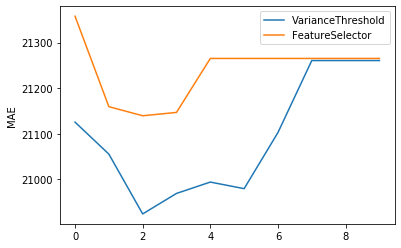

In [21]:
import matplotlib.pyplot as plt

def plot_lines(first_list, first_label, second_list, second_label):
    plt.plot(first_list, label=first_label)
    plt.plot(second_list, label=second_label)
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

def evaluate_transformer(col_trans, test_trans, test_params, X, y):
    mae_list = []
    for test_param in test_params:
        # Create a new Pipeline for each new transformer
        eval_pipe = Pipeline(steps=[
            ('preprocessor', col_trans),
            ('selector', test_trans(test_param)),
            ('model', LinearRegression())
        ])
        mae_list.append(evaluate_pipeline(eval_pipe, X, y))
    # Return the list of MAE values for test_trans
    return mae_list
 
print("Evaluating VarianceThreshold...")
thresholds = [1/n for n in range(2, 12)]
mae_vt = evaluate_transformer(col_trans, VarianceThreshold, thresholds, X, y)

print("\nEvaluating FeatureSelector...")
p_values = [1/(10**n) for n in range(1, 50, 5)]
mae_pv = evaluate_transformer(col_trans, FeatureSelector, p_values, X, y)

# Plot each list as a separate line
plot_lines(mae_vt, 'VarianceThreshold', mae_pv, 'FeatureSelector')

Okay, now it's confirmed, we need to do better. The strategy employed by FeatureSelector is consistently worse than using VarianceThreshold to select our columns. Lets see if we can improve its performance. This time we will use both the f-scores and the mutual information scores as our metric and we will keep the top_n scoring columns.

Selected features: [7, 15, 23, 31, 39, 47, 55, 63, 71, 79]

Evaluating FeatureSelector...
CV MAE: [24026.77570556 25864.25678128 25679.6228887 ], Mean MAE: 25190.218458513467
CV MAE: [22582.08981991 24190.75763609 24294.78592213], Mean MAE: 23689.21112604323
CV MAE: [21403.32026222 23384.99789147 22312.30151886], Mean MAE: 22366.873224185245
CV MAE: [20585.715248   22447.94807001 21064.17904778], Mean MAE: 21365.94745526293
CV MAE: [20259.67941606 22168.20423065 20938.63047798], Mean MAE: 21122.171374896894
CV MAE: [20474.94366938 22318.69925128 21098.71803753], Mean MAE: 21297.453652727858
CV MAE: [21331.77944413 21696.80238966 20875.05516696], Mean MAE: 21301.21233358481
CV MAE: [20766.3422746  21723.01763356 20733.5931868 ], Mean MAE: 21074.317698320174
CV MAE: [21064.99640441 21905.78317946 20263.26469267], Mean MAE: 21078.014758848047
CV MAE: [21336.31393464 21981.48313237 22506.23476036], Mean MAE: 21941.34394245506


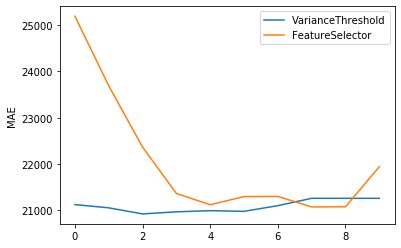

In [25]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# Our updated experimental transformer class
class FeatureSelector(TransformerMixin):
    def __init__(self, top_n=10):
        self.col_idx = []
        self.top_n = top_n
    
    def fit(self, X, y=None):
        f_array, _ = f_regression(X, y, False)
        mi_array = mutual_info_regression(X, y)
        # Indices of columns sorted by combined score (ascending)
        sorted_idx = np.argsort(f_array * mi_array)
        # Select the top_n column indices
        self.col_idx = sorted_idx[-1 * self.top_n:]
        return self
    
    def transform(self, X):
        return X[:, self.col_idx]

feature_counts = [int(X.shape[1] * (n/10)) for n in range(1, 11)]
print("Selected features: {}".format(feature_counts))

print("\nEvaluating FeatureSelector...")
mae_fc = evaluate_transformer(col_trans, FeatureSelector, feature_counts, X, y)
plot_lines(mae_vt, 'VarianceThreshold', mae_fc, 'FeatureSelector')

At least this time the custom Selector is more or less on par with our baseline.

## Advanced Pipelines
Even if this wasn't the most successful experiment, building a custom transformer helps with understanding what is going on under the hood. You might find that you can quickly gain an intuitive understanding of Pipelines just by exploring this type of functionality. 

From here there's nearly an unlimited set of possibilities when it comes to building our models and pipelines. The array of available estimators alone is impressive. Take a look at the Scikit-Learn [API Reference](https://scikit-learn.org/stable/modules/classes.html) to start getting acquainted with the tools at your disposal. 

Below is an example of a better performing pipeline for our LinearRegression model.

In [29]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

feature_count = 70

cat_trans_adv = Pipeline(steps=[
    ('encode', TargetEncoder(handle_unknown='return_nan')),
    ('impute', SimpleImputer(strategy='most_frequent'))
])

num_trans_adv = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('normalize', FunctionTransformer(np.log1p))
])
    
col_trans_adv = ColumnTransformer([
    ('num_impute', SimpleImputer(), num_cols),
    ('num_trans', num_trans_adv, num_cols),
    ('cat_trans', cat_trans_adv, cat_cols)
])
   
advanced_pipe = Pipeline(steps=[
    ('preprocessor', col_trans_adv),
    ('selector', FeatureSelector(feature_count)),
    ('model', LinearRegression())
])

evaluate_pipeline(advanced_pipe, X, y)

CV MAE: [19306.46349299 19507.15755156 18150.89418138], Mean MAE: 18988.171741974595


18988.171741974595